# Dungeons and Dragons Character Backstory Machine Learning Model

<a id="notebook-one-header"> </a>

## Goals
My hopes for this exploration and technical modeling project is to create a product that takes in user output (Character Name, Character Species, and Character Class), and returns to the user a generated backstory. 

## How to accomplish this?
I am utilizing both the database created by [@janelleshane](https://github.com/janelleshane/DnD_bios) and ChatGPT4 to generate brief backstories. I also got a few backstories from some friends. I combined all of these into one dataset and worked on cleaning and preprocessing the data. My focus was to clean up the backstories and remove any stopwords and lemmentize words. This was to prepare the data for a seq2seq model I would train. 

## User interaction and the product
Users would provide the input. The product takes the input and predicts which type of backstory was relavant to the user. A random backstory would be pull from all related backstory clusters and then fed to the seq2seq model. The user receives back a generated paragraph of text. 

## First Steps
Read in the data and begin the cleaning process. I removed any rows that did not contain backstories, as they were useless to me. 

## Predictive Models
Next I used the character species and class to create clusters for the backstories. This would be used to help feed a backstory to the seq2seq model.

## Generate Text
The trickiest and hardest part of this project is returning to the user a comprehendable paragraph of text to be used for a backstory.

___

## Desired ouput vs. MVP
Due to the difficulty of this task and the time constaint imposed by the project, I did have to alter my expectations for the product released. It doesn't seem feasible, withouth using a very high powered, well trained NLP model, like GPT4, to produce the results I was looking for. Therefore, the new product will provide the user with some ideas or a word bank to use in crafting a backstory for their character. 

(update)
Created product that did return a random string of words. The words themselves don't seem to fit well enough together to work as a descriptive word bank. 

____

## Focal Shift
As the project continued it became clear there were a few roadblockers for this product to be successful. After working through an [Experimental Notebook](notebook-two-experimental.ipynb#notebook-two-header) to explore the original dataset noted above, and cleaning the data more, it is clear that lack of data is a huge roadblock. The product is completing the task at hand, but to continuously train the model would lead to considerable overfitting. Given this fact, this project has shifted from product oriented to research oriented. 

## Begin with the EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import pickle

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, classification_report, silhouette_score

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

Initial work uses the combined dataset in hopes that more data will help with clustering

In [4]:
char_df = pd.read_csv('data/dd_bios_02.csv', encoding='ISO-8859-1')

char_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3447 entries, 0 to 3446
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   timestamp            2447 non-null   object
 1   character_name       3447 non-null   object
 2   character_species    3447 non-null   object
 3   character_class      3447 non-null   object
 4   character_backstory  3343 non-null   object
dtypes: object(5)
memory usage: 134.8+ KB


In [5]:
char_df = char_df.drop(columns=['timestamp'])


In [6]:
char_df.head()

,character_name,character_species,character_class,character_backstory
0,Erryt,Aarakocra,Ranger,"Erryt, a 7 year-old Aarakocra with golden plum..."
1,Katyusha,Aarakocra,Cleric,Real name Erryt\n\nLives in fantasy Soviet Uni...
2,Surkiikri,Aarakocra,Monk,Surkiikri was firstborn of the ruling family o...
3,Azriel,Aasamar,Paladin,He was raised the isles in a family of nobles ...
4,Azophyr,Aasimar,Paladin,Hi... I'm Azophyr. I'm a fallen aasimar devoti...


In [7]:
char_df = char_df.dropna()

In [8]:
char_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3343 entries, 0 to 3446
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   character_name       3343 non-null   object
 1   character_species    3343 non-null   object
 2   character_class      3343 non-null   object
 3   character_backstory  3343 non-null   object
dtypes: object(4)
memory usage: 130.6+ KB


In [9]:
char_df.character_species.unique()

array(['Aarakocra', 'Aasamar', 'Aasimar', 'aasimar', 'Alien', 'Android',
       'Anthropomorphic Cockroach', 'Aquatic Half-Elf', 'Beeforged',
       'Birali (homebrew, sort of like a cat-folk)',
       'Birali turned back to Human', 'Birdfolk', 'Blue Dragonborn',
       'BugBear', 'Cambion', 'Catfolk', 'Catgirl', 'Celestial',
       'Changeling', 'Copper Dragonborn', 'Dark Elf', 'dark elf',
       'Dark elf', 'Dark Elf/Human', 'Deep Gnome', 'Demon', 'Dragonborn',
       'Drow', 'drow', 'Drow Elf', 'Drow elf', 'Dwarf', 'dwarf',
       'Earth Genasi', 'Eladrin', 'Elan', 'Elf', 'elf', 'Elf (Drow)',
       'Elf (Wood)', 'Fey Corgi', 'Feyblood', 'Fire genasi',
       'Forest gnome', 'Forest Gnome', 'genasi', 'Genasi',
       'Ghostwise Halfling', 'Ghoul Medusa', 'Githyanki', 'Gnoll',
       'Gnome', 'gnome', 'goblin', 'Goblin', 'Goliath', 'goliath',
       'Grey Elf', 'Hafling', 'Half Cat folk/ Half Elf', 'Half drow',
       "Half dwarf, half elf/orc (don't question it)", 'Half Elf',
      

In [10]:
# Convert all values in the 'character_species' and 'character_class' column to lowercase
char_df['character_species'] = char_df['character_species'].str.lower()
char_df['character_class'] = char_df['character_class'].str.lower()
char_df['character_name'] = char_df['character_name'].str.lower()
char_df['character_backstory'] = char_df['character_backstory'].str.lower()


char_df['character_species'].value_counts()

character_species
human                   716
half-elf                172
elf                     152
tiefling                134
halfling                132
                       ... 
halfing                   1
sweet elf                 1
grey elf                  1
badger                    1
vengeful tree spirit      1
Name: count, Length: 342, dtype: int64

In [11]:
def replace_string_in_column(df, column, old_string, new_string):
    """
    Replaces occurrences of a specific string in a column with a new string.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the column.
    column (str): The column name where the replacement should happen.
    old_string (str): The string to search for.
    new_string (str): The string to replace the old one with.

    Returns:
    pd.DataFrame: The DataFrame with the updated column.
    """
    df.loc[df[column].str.contains(old_string, case=False, na=False), column] = new_string
    return df

We can clean up some glaring issues. There are still a lot of homebrew species, we will leave them as is.

In [12]:
char_df = replace_string_in_column(char_df, 'character_species', 'aasamar', 'aasimar')
char_df = replace_string_in_column(char_df, 'character_species', 'half elf', 'half-elf')
char_df = replace_string_in_column(char_df, 'character_species', 'half drow', 'half-elf (drow)')
char_df = replace_string_in_column(char_df, 'character_species', 'half-drow', 'half-elf (drow)')
char_df = replace_string_in_column(char_df, 'character_species', 'half-ord', 'half-orc')
char_df = replace_string_in_column(char_df, 'character_species', 'drow', 'elf (drow)')
char_df = replace_string_in_column(char_df, 'character_species', 'drow elf', 'elf (drow)')
char_df = replace_string_in_column(char_df, 'character_species', 'humam', 'human')


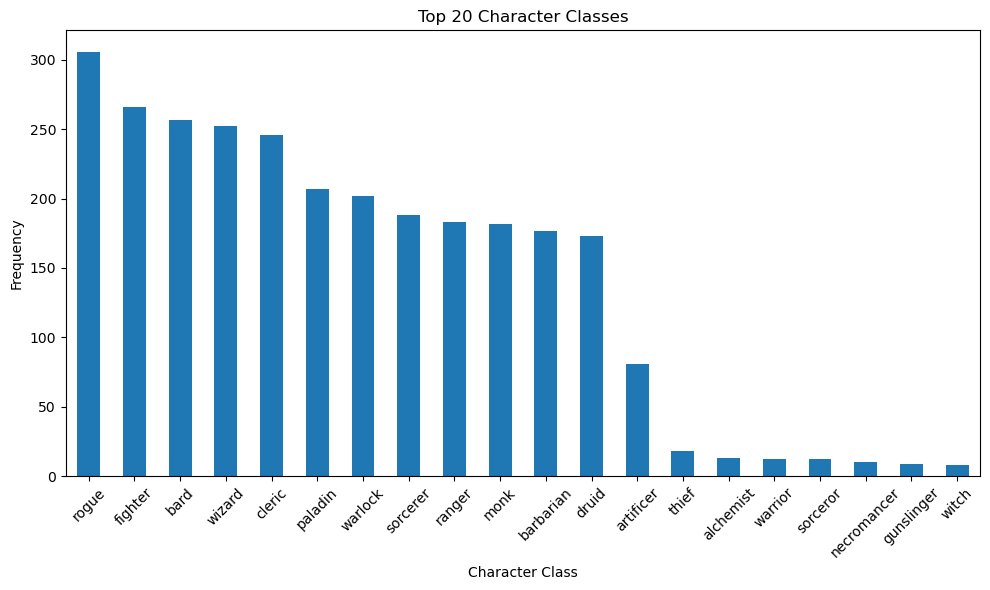

In [13]:
top_20_classes = char_df.character_class.value_counts().head(20)

# Create the plot
plt.figure(figsize=(10,6))
top_20_classes.plot(kind='bar')
plt.title('Top 20 Character Classes')
plt.xlabel('Character Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

This is a solid representation of the 5ed classes available, and a good number of other types of classes that make up this dataset. 

Let's start cleaning up the rest of the text to get ready for tokenization

In [14]:
# !pip install nltk

In [15]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

# Make sure you have stopwords and lemmatizer from NLTK
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

basic_token_pattern = r"(?u)\b\w\w+\b"
tokenizer = RegexpTokenizer(basic_token_pattern)
stop_words = set(stopwords.words('english'))

# Additional custom words to remove
custom_words = {"one", "would", "yet", "could", "though", "without", "like", "much"}
stop_words.update(custom_words)

lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dmm46\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dmm46\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
# Function to remove tokens that consist only of underscores
def clean_text(text):
    # Use regex to replace sequences of underscores with a space if they consist entirely of underscores
    return re.sub(r'\b_+\b', ' ', text)

In [17]:
# Preprocessing function: tokenization, lemmatization, and stopword removal
def preprocess_backstory(text):

    cleaned_text = clean_text(text)

    tokens = tokenizer.tokenize(cleaned_text.lower())  # Lowercase and tokenize
    
    # Remove stopwords first
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize the remaining tokens
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    # Remove custom words and numbers
    final_tokens = [word for word in lemmatized_tokens if not re.search(r'\d', word) and word.isalpha()]
    
    return ' '.join(final_tokens)  # Join tokens back into a string


In [18]:
def generative_backstory(text, max_len=100):
    """
    Function to fit a tokenizer on backstory text with stopwords included,
    and return the tokenized and padded sequence ready for text generation.

    Parameters:
    - text (list or string): The input text or list of backstory texts.
    - max_len (int): Maximum length for padding the sequence (default is 100).

    Returns:
    - tokenizer: The fitted tokenizer.
    - padded_sequences: Tokenized and padded sequences.
    """
    # Ensure input is a list (for multiple backstories) or convert to a list if it's a single string
    if isinstance(text, str):
        text = [text]

    # Tokenizer fitting on text WITH stopwords
    tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
    tokenizer.fit_on_texts(text)  # Fit tokenizer on the raw texts with stopwords

    # Convert texts to sequences
    sequences = tokenizer.texts_to_sequences(text)

    # Pad sequences to ensure consistent input length
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

    return tokenizer, padded_sequences

In [19]:
# Apply preprocessing to the character_backstory column
char_df['cleaned_backstory'] = char_df['character_backstory'].apply(preprocess_backstory)

In [20]:
char_df['generative_backstory'] = char_df['character_backstory'].apply(lambda x: generative_backstory(x)[1])

In [82]:
char_df['cleaned_backstory'][45]

'raised druid never stepped outside forrest know almost nothing outside world act strange'

In [83]:
char_df['character_backstory'][45]

'he was raised by druids and has never stepped outside their forrest. he knows almost nothing of the outside world and because of this he acts very strange.'

In [84]:
char_df['generative_backstory'][45]

array([[ 2,  6,  7,  8,  9,  3, 10, 11, 12,  4, 13, 14,  2, 15, 16, 17,
         5, 18,  4, 19,  3, 20,  5, 21,  2, 22, 23, 24,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]])

In [24]:
from collections import Counter

# Flatten all preprocessed backstories into one large list of words
all_words = ' '.join(char_df['cleaned_backstory']).split()

# Calculate word frequencies
word_freq = Counter(all_words)

In [25]:
sorted(word_freq)

['aaf',
 'aarackoan',
 'aarakocra',
 'aarakocran',
 'aaron',
 'aasimar',
 'aback',
 'abaewen',
 'abaewin',
 'abaivoi',
 'aballon',
 'abandon',
 'abandoned',
 'abandoning',
 'abandonment',
 'abated',
 'abato',
 'abbot',
 'abbott',
 'abby',
 'abbys',
 'abdication',
 'abducted',
 'abducting',
 'abel',
 'abernathy',
 'aberration',
 'aberrock',
 'abhorred',
 'abhorrent',
 'abhorring',
 'abhors',
 'abide',
 'abiding',
 'ability',
 'abject',
 'abjuration',
 'abjurer',
 'ablaze',
 'able',
 'abnormal',
 'aboard',
 'abode',
 'aboleth',
 'aboleths',
 'abolitionist',
 'abomination',
 'aborted',
 'abortive',
 'abound',
 'abounded',
 'abounding',
 'abrasive',
 'abrasiveness',
 'abraxas',
 'abraxos',
 'abres',
 'abridged',
 'abroad',
 'abrogail',
 'abrupt',
 'abruptly',
 'absalom',
 'absconded',
 'absence',
 'absent',
 'absentee',
 'absentism',
 'absentmindedly',
 'absolute',
 'absolutely',
 'absolution',
 'absolve',
 'absolved',
 'absorb',
 'absorbed',
 'absorbing',
 'absorbs',
 'abstalar',
 'abstra

The cleaned text looks better now after a few updated iterations of cleaning.

In [26]:
# Vectorize the cleaned backstories using TF-IDF
vectorizer = TfidfVectorizer()
vectored_backstory = vectorizer.fit_transform(char_df['cleaned_backstory'])

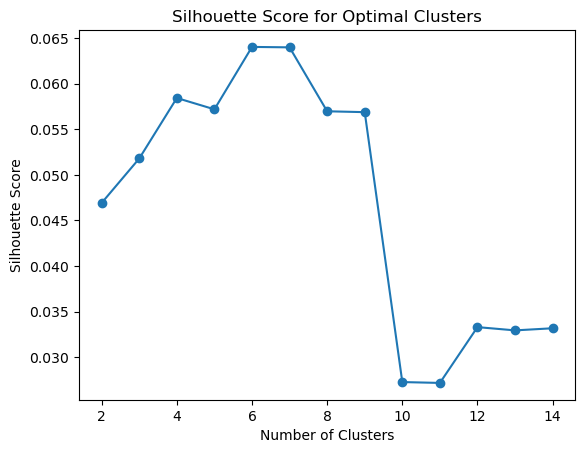

In [27]:
# Evaluate the Silhouette Score for different numbers of clusters
silhouette_scores = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(vectored_backstory)
    silhouette_scores.append(silhouette_score(vectored_backstory, labels))

# Plot the Silhouette Score
plt.plot(range(2, 15), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Clusters')
plt.show()

In [28]:
silhouette_scores

[0.046928577447044484,
 0.051799700072474544,
 0.05842745713565046,
 0.05718636131038318,
 0.0640270233207992,
 0.06397978196035746,
 0.05697199857767333,
 0.0568765099445584,
 0.027288363110701586,
 0.02719475176121043,
 0.03331161663857311,
 0.03295382208838105,
 0.033186652345159356]

In [29]:
max_value = max(silhouette_scores)
index_of_max = silhouette_scores.index(max_value)
index_of_max

4

Choose the number of clusters that yields the highest silhouette score.

In [30]:
# Use K-Means clustering to find themes
num_clusters = index_of_max+2  # Based on the silohuette score above. 
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(vectored_backstory)

# Add the cluster labels as the theme category
char_df['backstory_cluster'] = kmeans.fit_predict(vectored_backstory)



In [31]:
# View the DataFrame with the new cluster labels
print(char_df[['character_name', 'character_species', 'character_class', 'backstory_cluster']])

           character_name character_species character_class  backstory_cluster
0                   erryt         aarakocra          ranger                  2
1                katyusha         aarakocra          cleric                  2
2               surkiikri         aarakocra            monk                  0
3                  azriel           aasimar         paladin                  0
4                 azophyr           aasimar         paladin                  2
...                   ...               ...             ...                ...
3442    seren oakenshield          plasmoid        sorcerer                  1
3443               lirael               elf            monk                  1
3444               aelric             owlin         fighter                  1
3445      bruni firebrand             dwarf          wizard                  4
3446  aelric shadowdancer           bugbear       barbarian                  1

[3343 rows x 4 columns]


In [32]:
char_df

,character_name,character_species,character_class,character_backstory,cleaned_backstory,generative_backstory,backstory_cluster
0,erryt,aarakocra,ranger,"erryt, a 7 year-old aarakocra with golden plum...",erryt year old aarakocra golden plumage crest ...,"[[2, 43, 44, 3, 45, 8, 46, 15, 47, 2, 10, 48, ...",2
1,katyusha,aarakocra,cleric,real name erryt\n\nlives in fantasy soviet uni...,real name erryt life fantasy soviet union vale...,"[[27, 80, 28, 29, 81, 82, 83, 27, 3, 4, 29, 30...",2
2,surkiikri,aarakocra,monk,surkiikri was firstborn of the ruling family o...,surkiikri firstborn ruling family mistcliffs a...,"[[6, 23, 78, 10, 79, 3, 24, 80, 9, 2, 81, 3, 6...",0
3,azriel,aasimar,paladin,he was raised the isles in a family of nobles ...,raised isle family noble close tie god angelic...,"[[6, 8, 9, 2, 5, 10, 11, 12, 7, 13, 14, 15, 16...",0
4,azophyr,aasimar,paladin,hi... i'm azophyr. i'm a fallen aasimar devoti...,hi azophyr fallen aasimar devotion paladin enc...,"[[12, 4, 5, 4, 6, 13, 14, 15, 16, 17, 18, 19, ...",2
...,...,...,...,...,...,...,...
3442,seren oakenshield,plasmoid,sorcerer,"cora is a plasmoid sorcerer, known for their u...",cora plasmoid sorcerer known unmatched skill b...,"[[5, 12, 13, 14, 15, 16, 17, 3, 18, 19, 6, 20,...",1
3443,lirael,elf,monk,"lirael stormhand is a elf monk, known for thei...",lirael stormhand elf monk known unmatched skil...,"[[5, 6, 13, 14, 15, 16, 17, 18, 3, 19, 20, 7, ...",1
3444,aelric,owlin,fighter,"drake shadowdancer is a owlin fighter, known f...",drake shadowdancer owlin fighter known unmatch...,"[[5, 6, 13, 14, 15, 16, 17, 18, 3, 19, 20, 7, ...",1
3445,bruni firebrand,dwarf,wizard,"durin spent their youth in dusty libraries, po...",durin spent youth dusty library poring ancient...,"[[3, 11, 4, 12, 5, 13, 14, 15, 16, 17, 18, 6, ...",4


In [33]:
from collections import Counter

# Function to get word frequency for a cluster
def get_word_frequency(cluster_num):
    # Filter rows belonging to the specified cluster
    cluster_text = char_df[char_df['backstory_cluster'] == cluster_num]['cleaned_backstory']
    
    # Join all backstories in the cluster into a single string
    all_words = ' '.join(cluster_text).split()
    
    # Use Counter to get word frequencies
    word_freq = Counter(all_words)
    
    # Get the top 10 most common words in the cluster
    return word_freq.most_common(10)

# Loop over each cluster and get word frequencies
n_clusters = char_df['backstory_cluster'].nunique()  # Find the number of unique clusters

for cluster_num in range(n_clusters):
    print(f"\nCluster {cluster_num} - Top Words:")
    top_words = get_word_frequency(cluster_num)
    for word, freq in top_words:
        print(f"{word}: {freq}")


Cluster 0 - Top Words:
monastery: 124
home: 97
world: 71
left: 59
family: 50
monk: 49
find: 49
training: 49
way: 49
life: 47

Cluster 1 - Top Words:
known: 607
unmatched: 607
skill: 607
battle: 607
unwavering: 607
loyalty: 607
comrade: 607
journeyed: 607
far: 607
wide: 607

Cluster 2 - Top Words:
time: 1307
family: 1300
year: 1204
life: 1165
father: 1019
mother: 1002
day: 968
way: 896
found: 878
never: 803

Cluster 3 - Top Words:
ancient: 158
forest: 158
cora: 120
bryn: 80
raised: 79
nature: 79
time: 79
walk: 79
felt: 79
pulse: 79

Cluster 4 - Top Words:
darkest: 238
bryn: 218
cora: 198
shadow: 178
drake: 174
hand: 168
youth: 159
seek: 159
know: 159
heart: 158

Cluster 5 - Top Words:
power: 152
bryn: 88
never: 76
intended: 76
make: 76
pact: 76
force: 76
beyond: 76
world: 76
desperation: 76


______

To begin predicting on these clusters, we will need to turn the features into numerical data

_______

In [34]:
# Step 1: Encode categorical features (name, species, class) into numeric form
le_name = LabelEncoder()
le_species = LabelEncoder()
le_class = LabelEncoder()

char_df['encoded_name'] = le_name.fit_transform(char_df['character_name'])
char_df['encoded_species'] = le_species.fit_transform(char_df['character_species'])
char_df['encoded_class'] = le_class.fit_transform(char_df['character_class'])

In [35]:
# Features and target
X = char_df[['encoded_species', 'encoded_class']]
y = char_df['backstory_cluster']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Trying to balance my classes with some SMOTE

In [36]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

____

## Basic Machine Learning Shotgun Approach


____

In [37]:
# Define the models to try
models = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Support Vector Classifier': SVC(),
    'Naive Bayes': MultinomialNB(),  # Naive Bayes often works well with categorical data
    'XGBoost': XGBClassifier()
}

In [38]:
# Go through all models to see best out of the box
for model_name, model in models.items():
    if model_name == 'Naive Bayes':
        # Use MinMaxScaler for MultinomialNB
        pipeline = Pipeline([
            ('scaler', MinMaxScaler()),  # Use MinMaxScaler for Naive Bayes to avoid negative values
            ('classifier', model)
        ])
    else:
        # Use StandardScaler for the other models
        pipeline = Pipeline([
            ('scaler', StandardScaler()),  # Use StandardScaler for other models
            ('classifier', model)
        ])
    
    # Train the model
    pipeline.fit(X_resampled, y_resampled)
    
    # Predict and evaluate
    y_pred = pipeline.predict(X_test)
    
    # Classification report
    print(f"Results for {model_name}:")
    print(classification_report(y_test, y_pred, zero_division=0))

Results for Random Forest:
              precision    recall  f1-score   support

           0       0.17      0.27      0.21        52
           1       0.59      0.74      0.66       108
           2       0.83      0.66      0.74       440
           3       0.58      0.79      0.67        14
           4       0.57      0.83      0.68        42
           5       0.55      0.92      0.69        13

    accuracy                           0.66       669
   macro avg       0.55      0.70      0.61       669
weighted avg       0.71      0.66      0.68       669

Results for Logistic Regression:
              precision    recall  f1-score   support

           0       0.25      0.21      0.23        52
           1       0.21      0.10      0.14       108
           2       0.71      0.17      0.27       440
           3       0.06      0.93      0.10        14
           4       0.09      0.26      0.13        42
           5       0.12      1.00      0.22        13

    accuracy     

____

Random Forest turned out the best initial accuracy, a very low 42%. Let's try and improve on that.\
XGBoost gave us 44%

UPDATE:\
After doing some more prepocessing of the text to remove some more dirty data and stopwords we are getting better accuracy out of the gate.\
Random Forest is giving 74%\
XGBoost is giving 78%

_____

In [39]:
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, 30],
#     'min_samples_split': [2, 5, 10]
# }

# rf = RandomForestClassifier(class_weight='balanced', random_state=42)
# grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# best_rf = grid_search.best_estimator_
# y_pred = best_rf.predict(X_test)

# print(f"Best Parameters: {grid_search.best_params_}")
# print(classification_report(y_test, y_pred))

____

grid search made it worse!

____

In [40]:
# model = RandomForestClassifier(class_weight='balanced', random_state=42)
# scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
# print(f"Mean accuracy: {scores.mean()}")

Using the voting classifier, we can use mulitple models together. 

In [41]:
from sklearn.ensemble import VotingClassifier

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Apply scaling
    ('classifier', LogisticRegression(solver='saga', max_iter=500, random_state=42))
])

model1 = RandomForestClassifier(class_weight='balanced', random_state=42)
# model2 = LogisticRegression(max_iter=500, random_state=42)
model3 = SVC(probability=True, class_weight='balanced', random_state=42)
model4 = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

ensemble_model = VotingClassifier(estimators=[
    ('rf', model1), ('lr', pipeline), ('svc', model3), ('xgb', model4)],
    voting='soft')

ensemble_model.fit(X_resampled, y_resampled)
y_pred = ensemble_model.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))

c:\Users\dmm46\miniconda3\envs\tf-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [09:39:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.17      0.27      0.21        52
           1       0.62      0.78      0.69       108
           2       0.85      0.60      0.70       440
           3       0.45      1.00      0.62        14
           4       0.55      0.86      0.67        42
           5       0.33      1.00      0.49        13

    accuracy                           0.64       669
   macro avg       0.49      0.75      0.56       669
weighted avg       0.72      0.64      0.66       669



___

We are up to 45%, not really amazing at all.\ 
Added xgboost and got to 47%. There are a lot of zeroed out classes here. 

UPDATE:\
Again, we have better accuracy out of the gate. We are look at 78% with better f-scores overall than previously

____

Let's stick with XGBoost

In [42]:

# Define the pipeline with scaling and the XGBClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Apply scaling
    ('classifier', XGBClassifier(eval_metric='mlogloss', random_state=42))
])

# Fit the model
pipeline.fit(X_resampled, y_resampled)

# Make predictions
y_pred = pipeline.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.16      0.29      0.20        52
           1       0.61      0.76      0.67       108
           2       0.86      0.65      0.74       440
           3       0.57      0.93      0.70        14
           4       0.59      0.86      0.70        42
           5       0.55      0.92      0.69        13

    accuracy                           0.66       669
   macro avg       0.55      0.73      0.62       669
weighted avg       0.73      0.66      0.68       669



In [43]:
from sklearn.utils.class_weight import compute_class_weight

# Get the class distribution
classes = np.unique(y_resampled)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_resampled)

# Create a dictionary of class weights
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Update your XGBClassifier with class weights
xgb_clf = XGBClassifier(eval_metric='mlogloss', random_state=42, scale_pos_weight=class_weights_dict)

# # Define the parameter grid for hyperparameter tuning
# param_grid = {
#     'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
#     'classifier__max_depth': [3, 4, 5, 6, 7],
#     'classifier__n_estimators': [100, 200, 300, 400, 500]
# }

# Best hyperparameters: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 7, 'classifier__n_estimators': 500}
param_grid = {
    'classifier__learning_rate': [0.05],
    'classifier__max_depth': [7],
    'classifier__n_estimators': [500]
}

# Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Apply scaling
    ('classifier', xgb_clf)
])

# Set up GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, scoring='f1_weighted', cv=10, verbose=1, n_jobs=-1, refit=True)


# Train the model
grid_search.fit(X_resampled, y_resampled)

# Make predictions
y_pred = grid_search.best_estimator_.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

# Get the best parameters from the grid search
print("Best hyperparameters:", grid_search.best_params_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\dmm46\miniconda3\envs\tf-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [09:39:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.13      0.23      0.16        52
           1       0.61      0.76      0.67       108
           2       0.85      0.65      0.73       440
           3       0.57      0.93      0.70        14
           4       0.58      0.86      0.69        42
           5       0.55      0.92      0.69        13

    accuracy                           0.66       669
   macro avg       0.55      0.72      0.61       669
weighted avg       0.73      0.66      0.68       669

Best hyperparameters: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 7, 'classifier__n_estimators': 500}


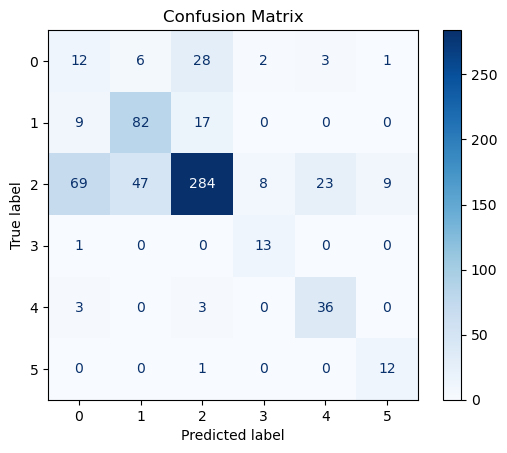

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

____ 

## Saving content section
uncomment when necessary

____

In [45]:
# import json

# # After grid search, extract the best XGBClassifier from the pipeline
# best_xgb_model = grid_search.best_estimator_.named_steps['classifier']

# # Save the XGBoost model to JSON
# best_xgb_model.save_model('xgb_model.json')

In [46]:
# # Save the model in binary format
# best_xgb_model.save_model('word_bank_app/xgb_model.model')

In [47]:
# import joblib

# # Save the trained model to a file
# joblib.dump(grid_search.best_estimator_, 'word_bank_app/trained_xgb_model.pkl')

In [48]:
# import pickle

# # Save the trained pipeline model using pickle
# with open('word_bank_app/trained_pipeline.pkl', 'wb') as model_file:
#     pickle.dump(grid_search.best_estimator_, model_file)

In [49]:
# # Replace 'your_dataframe' with the actual name of your dataframe
# char_df.to_csv('cleaned_df.csv', index=False)

____

## Testing functionality for product

____

In [50]:
input_species = 'lizard'
input_class = 'druid'  


species_encoder = dict(zip(char_df['character_species'].str.lower(), char_df['encoded_species']))
class_encoder = dict(zip(char_df['character_class'].str.lower(), char_df['encoded_class']))


encoded_species = species_encoder.get(input_species.lower(), -1)
encoded_class = class_encoder.get(input_class.lower(), -1)

# Check if any encoding failed
if -1 in [encoded_species, encoded_class]:
    print("Error: One of the input values is invalid.")
else:
    # Combine the encoded values into a feature array
    input_features = np.array([[encoded_species, encoded_class]])

    # Use the trained model to predict the cluster
    predicted_cluster = grid_search.best_estimator_.predict(input_features)

    # Output the predicted cluster
    print(f"The predicted cluster for the character is: {predicted_cluster[0]}")

The predicted cluster for the character is: 3


c:\Users\dmm46\miniconda3\envs\tf-gpu\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


________
## Neural Net Work
______

In [51]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding

texts = char_df['cleaned_backstory'].tolist()

_____

In [52]:
# Tokenize and prepare data
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

# Save the tokenizer to a file
with open('word_bank_app/tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

vocab_size = len(tokenizer.word_index) + 1

# Convert texts to sequences of word indices
sequences = tokenizer.texts_to_sequences(texts)

# Define max_len (adjustable)
max_len = 100

# Generator function to yield batches of data
def data_generator(sequences, batch_size, max_len, vocab_size):
    num_samples = len(sequences)
    while True:
        for offset in range(0, num_samples, batch_size):
            # Create a batch of input sequences (X) and target sequences (y)
            X_batch = [seq[:-1] for seq in sequences[offset:offset + batch_size]]
            y_batch = [seq[1:] for seq in sequences[offset:offset + batch_size]]
            
            # Pad sequences to max_len
            X_batch = pad_sequences(X_batch, maxlen=max_len, padding='post')
            y_batch = pad_sequences(y_batch, maxlen=max_len, padding='post')
            
            # Convert to float32 to reduce memory usage
            X_batch = X_batch.astype('float32')
            y_batch = np.array([np.eye(vocab_size)[seq] for seq in y_batch], dtype='float32')
            
            yield [X_batch, X_batch], y_batch  # Yield inputs and targets as a tuple

# Model definition
embedding_dim = 64
latent_dim = 128 # reducing this from 256 since data set isn't super large. 

# Encoder
encoder_inputs = Input(shape=(max_len,))
encoder_embedding = Embedding(vocab_size, embedding_dim, input_length=max_len)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True, dropout=0.2) # adding dropouts to help with overfitting
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding) # get the hidden state and cell state
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_len,))
decoder_embedding = Embedding(vocab_size, embedding_dim, input_length=max_len)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the full model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set batch size and number of steps per epoch
batch_size = 16
steps_per_epoch = len(sequences) // batch_size



In [53]:
print(tokenizer.word_index.get('and'))  # Should return a valid index

None


In [54]:
# Print out the first 20 words in the tokenizer's vocabulary
for word, index in list(tokenizer.word_index.items())[:20]:
    print(f"{word}: {index}")

<OOV>: 1
world: 2
way: 3
time: 4
family: 5
life: 6
year: 7
always: 8
day: 9
father: 10
mother: 11
known: 12
far: 13
eye: 14
battle: 15
found: 16
skill: 17
never: 18
shadow: 19
along: 20


In [55]:
# # Train the model using the updated `fit` method
# model.fit(data_generator(sequences, batch_size, max_len, vocab_size), 
#           steps_per_epoch=steps_per_epoch, epochs=50)

In [56]:
# # Save the model after training
# model.save('seq2seq_model.h5')

In [57]:
# # Save the model after training
# model.save('seq2seq_new_clean_model.h5')

In [58]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('word_bank_app/seq2seq_new_clean_model.h5')

In [59]:
# # Resume training from where it left off
# model.fit(data_generator(sequences, batch_size, max_len, vocab_size), 
#           steps_per_epoch=steps_per_epoch, epochs=50)

In [60]:
# from tensorflow.keras.optimizers import Adam

# # Lower the learning rate to fine-tune
# model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# # Continue training
# model.fit(data_generator(sequences, batch_size, max_len, vocab_size), 
#           steps_per_epoch=steps_per_epoch, epochs=50)

In [61]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 100, 64)      1505216     ['input_6[0][0]']                
                                                                                                  
 embedding_6 (Embedding)        (None, 100, 64)      1505216     ['input_7[0][0]']                
                                                                                            

In [62]:
# from tensorflow.keras.callbacks import ModelCheckpoint

# # Create a callback to save the model after each epoch
# checkpoint = ModelCheckpoint('seq2seq_checkpoint.h5', save_best_only=True, monitor='loss', mode='min')

# # Train the model with the checkpoint callback
# model.fit(data_generator(sequences, batch_size, max_len, vocab_size), 
#           steps_per_epoch=steps_per_epoch, epochs=50, callbacks=[checkpoint])

In [63]:
# # Save the model after training
# model.save('seq2seq_02_model.h5')

In [64]:
# Step 1: Define inference models

# Encoder model for inference
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder model for inference
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Retrieve the correct embedding layer for the decoder ('embedding_6')
decoder_embedding_layer = model.get_layer('embedding_6')  # Use the correct decoder embedding layer name
decoder_inputs_inf = Input(shape=(1,))  # One word at a time
decoder_embedding_inf = decoder_embedding_layer(decoder_inputs_inf)

# Decoder LSTM (for inference, one word at a time)
decoder_lstm_inf, state_h_inf, state_c_inf = decoder_lstm(decoder_embedding_inf, initial_state=decoder_states_inputs)
decoder_states_inf = [state_h_inf, state_c_inf]

# Dense layer to generate the next word
decoder_outputs_inf = decoder_dense(decoder_lstm_inf)

# Define the decoder model for inference
decoder_model = Model([decoder_inputs_inf] + decoder_states_inputs, [decoder_outputs_inf] + decoder_states_inf)

In [65]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_6 (Embedding)        multiple             1505216     ['input_5[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 128)]        0           []                               
                                                                                            

In [66]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 64)           1505280   
                                                                 
 lstm (LSTM)                 [(None, 128),             98816     
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
Total params: 1,604,096
Trainable params: 1,604,096
Non-trainable params: 0
_________________________________________________________________


In [67]:
# !pip install pydot

In [68]:
# Save the encoder model
encoder_model.save('word_bank_app/encoder_model.h5')

# Save the decoder model
decoder_model.save('word_bank_app/decoder_model.h5')

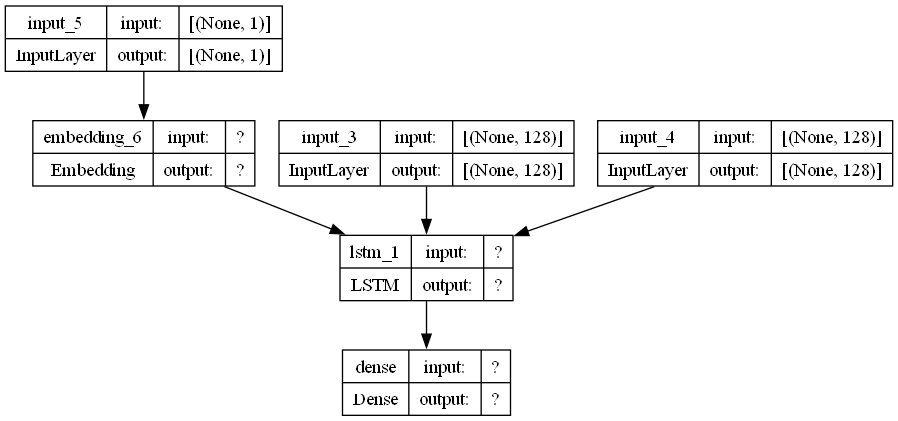

In [69]:
from tensorflow.keras.utils import plot_model
plot_model(decoder_model, to_file='decoder_model.png', show_shapes=True, show_layer_names=True)

In [70]:
# Adding a temperature parameter

def sample_with_temperature(predictions, temperature=0.2):
    predictions = np.asarray(predictions).astype('float64')
    predictions = np.log(predictions + 1e-8) / temperature
    exp_preds = np.exp(predictions)
    predictions = exp_preds / np.sum(exp_preds)
    return np.random.choice(range(len(predictions)), p=predictions)

In [71]:
def generate_text(input_seq, tokenizer, max_len, temperature=0.2):
    # Encode the input sequence to get the initial state
    states_value = encoder_model.predict(input_seq)

    # # Prepare the target sequence (start with the "start" token or first word)
    # target_seq = np.zeros((1, 1))  # Decoder input starts with a single token
    # target_seq[0, 0] = tokenizer.word_index.get('start', 1)  # Use 'start' token or default token

    # Prepare the target sequence using the seed sequence (first four words)
    target_seq = input_seq[:, :1]  # Start with the first word of the input sequence

    # Initialize the output sequence
    stop_condition = False
    generated_text = []

     # If you want to preserve the first four words in the generated text
    # Add them directly to the generated_text list
    for word_id in input_seq[0]:
        if word_id != 0:  # Avoid padding tokens
            generated_text.append(tokenizer.index_word.get(word_id, ''))
    
    while not stop_condition:
        # Predict the next word using decoder model
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample the next word using temperature-based sampling
        sampled_token_index = sample_with_temperature(output_tokens[0, -1, :], temperature)
        sampled_word = tokenizer.index_word.get(sampled_token_index, '')

        # Add the word to the generated text
        generated_text.append(sampled_word)

        # Stop if 'end' token is predicted or sequence is too long
        if sampled_word == 'end' or len(generated_text) >= max_len:
            stop_condition = True

        # Update the target sequence (shift the word) and update states
        target_seq = np.zeros((1, 1))  # Prepare for the next word
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    return ' '.join(generated_text)

In [73]:
sample_sentence = char_df['cleaned_backstory'][60]

first_four_words = ' '.join(sample_sentence.split()[:4])

first_four_words

'joined flotilla young group'

In [74]:
char_df['character_backstory'][60]

"she joined the flotilla when she was young, a group of found family with strict codes of honor about sharing resources, helping the needy, and embracing adventure and differences. it's a philosophy born from a people who escaped the servitude of an aboleth. she found that open air of acceptance and community especially comforting after her decision to come out of the closet and live as the woman she always knew she was. when she became a young adult, the flotilla sent her out on her sailabout, a sort of spiritual journey around the world to learn about and help the world. she's expected to contribute something of value to her community upon her return."

In [75]:
sample_sentence

'joined flotilla young group found family strict code honor sharing resource helping needy embracing adventure difference philosophy born people escaped servitude aboleth found open air acceptance community especially comforting decision come closet live woman always knew became young adult flotilla sent sailabout sort spiritual journey around world learn help world expected contribute something value community upon return'

In [77]:
# Test generation with a seed sequence
seed_text = first_four_words  # Use a starting text from your data
seed_sequence = tokenizer.texts_to_sequences([seed_text])
seed_sequence = pad_sequences(seed_sequence, maxlen=max_len, padding='post')

In [78]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\dmm46\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

____

Can we add more nuance to the sentences with some filler words and punctuation?

____

In [79]:
import random

# List of filler words categorized by parts of speech
filler_words_by_pos = {
    'NN': ['the', 'a', 'some', 'this', 'that', 'any', 'one', 'each'],  # Articles and determiners for nouns
    'VB': ['is', 'was', 'has', 'will', 'might', 'can', 'could', 'would', 'should'],  # Auxiliary verbs
    'JJ': ['very', 'quite', 'rather', 'extremely', 'fairly', 'pretty', 'really', 'somewhat'],  # Intensifiers for adjectives
    'IN': ['with', 'by', 'on', 'from', 'under', 'over', 'through', 'in', 'around', 'at'],  # Prepositions
    'RB': ['probably', 'definitely', 'clearly', 'certainly', 'obviously', 'possibly', 'evidently'],  # Adverbs for verbs/adjectives
    'CC': ['and', 'or', 'but', 'so', 'yet'],  # Conjunctions
    'PRP': ['he', 'she', 'it', 'they', 'we', 'you', 'I'],  # Pronouns for general context
    'MD': ['will', 'would', 'can', 'could', 'might', 'must', 'should', 'shall'],  # Modal verbs
}

# Function to intelligently add filler words using POS tagging
def add_filler_words_smart(generated_text, filler_words_by_pos, insertion_prob=0.3):
    words = nltk.word_tokenize(generated_text)  # Tokenize the text
    pos_tags = nltk.pos_tag(words)  # Get POS tags for the generated text
    new_text = []
    
    for word, pos in pos_tags:
        new_text.append(word)
        
        # If the word's POS is in our filler_words_by_pos dictionary, insert a filler word
        if pos in filler_words_by_pos and random.random() < insertion_prob:
            filler_word = random.choice(filler_words_by_pos[pos])
            new_text.append(filler_word)
    
    return ' '.join(new_text)



In [80]:
# Function to generate structured sentences using POS tagging on enhanced text
def generate_structured_text(enhanced_text, max_sent_len=10):
    words = nltk.word_tokenize(enhanced_text)  # Tokenize the text into words
    pos_tags = nltk.pos_tag(words)  # Get POS tags for the words
    
    generated_sentences = []
    current_sentence = []

    # Iterate through the POS tagged words and structure sentences
    for word, pos in pos_tags:
        current_sentence.append(word)
        
        # Define basic sentence-ending logic based on POS
        # End the sentence if a noun, verb, or adjective has been seen and sentence is long enough
        if pos in ('NN', 'VB', 'JJ') and len(current_sentence) >= max_sent_len:
            generated_sentences.append(' '.join(current_sentence))
            current_sentence = []
    
    # Add any remaining words as the last sentence
    if current_sentence:
        generated_sentences.append(' '.join(current_sentence))

    # Join the sentences with punctuation
    punctuated_text = '. '.join(generated_sentences) + '.'
    
    return punctuated_text


In [81]:
# Example usage after generating text
generated_text = generate_text(seed_sequence, tokenizer, max_len)

# Generate the enhanced text by inserting filler words based on POS tags
enhanced_text = add_filler_words_smart(generated_text, filler_words_by_pos)

punctuated_text = generate_structured_text(enhanced_text)

print("Generated text with smart fillers:", punctuated_text)

1/1 [==============================] - 0s 20ms/step
Generated text with smart fillers: joined < OOV > young group unseeing tip farmstead innately vineless. conjunction leaved raud galen pippin ashlands initial vein gavrain delicious. honesty xandor lowborn rampage engagement hacker racer the wrenn blurted character each bakkal. that crosswood sunny this consented rescuing brimstone the vr dabbled ups. dragoneyes playful defeated invest backstreet bringer amongst a solomon unsubstantiated. inexplicable genuinely calloused gunnleif artefact the old somewhat regularity painting sapients wyrm. dunlin sparing handily ducky somewhat yen investigator one aside hayato. rather streetwise mythology glossed scraping helping zer accolade paramount railway. hindrance some rebuilding express yozi rotation endured swing ciara previously shroud rather absolute. rather luckily stilt justify enveloped throat shipwrecked calvados obessed holo infatuated miserable. petrograd dolphin this issachar this che

We are getting better text, but it is still a bit odd. One example:

Generated text with smart fillers: queen rather never pretending noise rate started skin a found. wear wave some punched poor klaetus stopped figure best enough find something. sure quite despite shown god punched ashamed reputation some prison. some non often totally sense debt actively going place determine. curse the needed view world realise regarding wisdom particularly lessened desperately currently hook. trust stood man remain remains mad rather earning name a person. money despite guess began get song introduced natured first intention. suffering possible add seat slew took recognize face skill fault. around future very almost seemed work embracing time the family. even friend rather since by day a mother dad childhood. name a feel redemption some way adventurer a also goal.

____

## Transformer Section (Turned off for now)
____

In [126]:
# !pip install transformers


In [127]:
# from transformers import TFAutoModelForMaskedLM, RobertaTokenizer, AutoTokenizer, TFRobertaForMaskedLM, TFAutoModelForCausalLM

In [128]:
# # Load BERT for masked language modeling
# bert_model_name = "bert-base-uncased"
# tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
# bert_model = TFAutoModelForMaskedLM.from_pretrained(bert_model_name)

# def refine_with_bert(text):
#     # Replace specific words with [MASK] token for BERT to predict
#     masked_text = text.replace("some", "[MASK]")
#     inputs = tokenizer.encode(masked_text, return_tensors="tf")
#     outputs = bert_model(inputs)
#     predictions = outputs.logits

#     # Get the predicted word for [MASK]
#     mask_token_index = tf.where(inputs == tokenizer.mask_token_id)[0, 1]
#     predicted_token_id = tf.argmax(predictions[0, mask_token_index], axis=-1)
#     predicted_token = tokenizer.decode(predicted_token_id)
#     print(f'token:{predictions[0, mask_token_index]}')
#     print(f'predict:{predicted_token_id}')
#     # print(predicted_token)

#     refined_text = masked_text.replace("[MASK]", predicted_token)
#     return refined_text

# # Example usage
# pre_generated_text = punctuatated_text
# refined_text = refine_with_bert(pre_generated_text)
# print("Refined text with BERT:", refined_text)

BERT is not giving anything different from the seq2seq process. Leaving out for now

In [129]:
# # Load RoBERTa tokenizer and model
# roberta_model_name = "roberta-base"
# tokenizer = RobertaTokenizer.from_pretrained(roberta_model_name)
# roberta_model = TFRobertaForMaskedLM.from_pretrained(roberta_model_name)

# def refine_with_roberta(text, max_length=100):
#     # Tokenize the input text
#     inputs = tokenizer.encode_plus(
#         text, 
#         return_tensors="tf", 
#         max_length=512,  # Adjust this value based on your input size
#         truncation=True,
#         padding="max_length"  # Ensure inputs are properly padded
#     )

#     # Masked language models don't use 'generate', they predict based on masked tokens.
#     # For example, to predict masked words:
#     input_ids = inputs['input_ids']

#     # Get the model output (logits) for masked language modeling
#     outputs = roberta_model(input_ids)
#     logits = outputs.logits

#     # Optionally, you could sample a prediction by selecting the token with the highest score
#     predicted_token_ids = tf.argmax(logits, axis=-1)
    
#     # Decode the tokens into words
#     refined_text = tokenizer.decode(predicted_token_ids[0], skip_special_tokens=True)
#     return refined_text

# # Example usage with generated text
# pre_generated_text = punctuatated_text
# refined_text = refine_with_roberta(pre_generated_text)

# print("Refined text with RoBERTa:", refined_text)

roBERTa did not result in a good text generation.

In [130]:
# # Load GPT-2 model and tokenizer in TensorFlow
# tokenizer = AutoTokenizer.from_pretrained("gpt2")
# gpt2_model = TFAutoModelForCausalLM.from_pretrained("gpt2")

# def refine_with_tf_gpt2(text, max_length=250):
#     inputs = tokenizer.encode(text, return_tensors="tf")
#     attention_mask = tf.ones_like(inputs)  # Create attention mask with all ones

#     # Generate text with specified attention mask and pad_token_id
#     outputs = gpt2_model.generate(
#         inputs,
#         attention_mask=attention_mask,  # Pass attention mask
#         max_length=max_length,
#         num_return_sequences=1,
#         pad_token_id=tokenizer.eos_token_id  # Set the pad_token_id to eos_token_id (50256)
#     )

#     refined_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
#     return refined_text

# # Example usage with generated text
# pre_generated_text = punctuatated_text
# refined_text = refine_with_tf_gpt2(pre_generated_text)
# print("Refined text with TF-GPT2:", refined_text)

GPT-2 not doing any better than BERT